In [44]:
#All imports
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import collections
from tqdm.auto import tqdm
import torchvision.datasets as datasets
import matplotlib.pyplot as plt


In [31]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

#Training data
mnist_traindata = mnist_trainset.data.numpy()
mnist_trainlabel = mnist_trainset.targets.numpy()
print("Training data",mnist_traindata.shape)
print("Training labels",mnist_trainlabel.shape)

#Testing data
mnist_testdata = mnist_testset.data.numpy()
mnist_testlabel = mnist_testset.targets.numpy()
print("Testing data",mnist_testdata.shape)
print("Testing labels",mnist_testlabel.shape)

Training data (60000, 28, 28)
Training labels (60000,)
Testing data (10000, 28, 28)
Testing labels (10000,)


In [32]:
##################################################
import torchvision.datasets as datasets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=False, transform=None)


# one hot encoding
def one_hot_encode(labels, num_classes):
    one_hot_labels = np.zeros((labels.size, num_classes))
    one_hot_labels[np.arange(labels.size), labels] = 1
    return one_hot_labels

#Training data
mnist_traindata = mnist_trainset.data.numpy()
mnist_trainlabel = mnist_trainset.targets.numpy()

mnist_trainlabel = one_hot_encode(mnist_trainlabel, 10)

print("Training data",mnist_traindata.shape)
print("Training labels",mnist_trainlabel.shape)

#Testing data
mnist_testdata = mnist_testset.data.numpy()
mnist_testlabel = mnist_testset.targets.numpy()

mnist_testlabel = one_hot_encode(mnist_testlabel, 10)

print("Testing data",mnist_testdata.shape)
print("Testing labels",mnist_testlabel.shape)

Training data (60000, 28, 28)
Training labels (60000, 10)
Testing data (10000, 28, 28)
Testing labels (10000, 10)


5

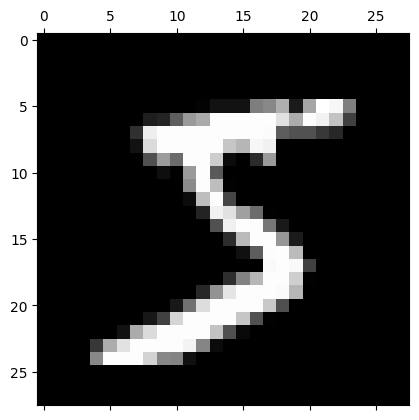

In [33]:
i = 0
plt.matshow(mnist_traindata[i], cmap='gray')
np.argmax(mnist_trainlabel[i])

#### Activation Functions

In [34]:
def ReLu(inp):
  outp = np.maximum(0, inp)
  return outp

def gradReLu(inp):
  outp = (inp > 0).astype(float)
  return outp

def sigmoid(inp):
    inp = np.clip(inp, -500, 500) # for numerical stability
    return 1 / (1 + np.exp(-inp))

def gradSigmoid(inp):
    sig = sigmoid(inp)
    return sig * (1 - sig)

def tanh(inp):
    return np.tanh(inp)

def gradTanh(inp):
    tanh_val = np.tanh(inp)
    return 1 - tanh_val ** 2

def LeakyReLu(inp, alpha=0.01):
    return np.where(inp > 0, inp, alpha * inp)

def gradLeakyReLu(inp, alpha=0.01):
    return np.where(inp > 0, 1, alpha)

def softmax(inp):
  exp_inp = np.exp(inp - np.max(inp, axis=1, keepdims=True))  # for numerical stability
  outp = exp_inp / np.sum(exp_inp, axis=1, keepdims=True)
  return outp

In [35]:
def fwdPropagate(X, weights, psi=ReLu):
    W1, W2, W3, b1, b2, b3 = weights

    A1 = X @ W1 + b1
    Z1 = psi(A1)

    A2 = Z1 @ W2 + b2
    Z2 = psi(A2)

    A3 = Z2 @ W3 + b3
    Z3 = softmax(A3)  
    
    return [Z1, Z2, Z3, A1, A2, A3]

def applyGradients(weights, gradients, learning_rate):
  W1, W2, W3, b1, b2, b3 = weights
  
  dW1, dW2, dW3, db1, db2, db3 = gradients

  W1 -= learning_rate * dW1
  W2 -= learning_rate * dW2
  W3 -= learning_rate * dW3

  b1 -= learning_rate * db1
  b2 -= learning_rate * db2
  b3 -= learning_rate * db3

  return [W1, W2, W3, b1, b2, b3]

def computeGradients(X, T, weights , activations, psi_prime):
    W1, W2, W3, b1, b2, b3 = weights
    Z1, Z2, Z3, A1, A2, A3 = activations

    E3 = (Z3 - T)
    dW3 = (Z2.T @ E3)

    E2 = (E3 @ W3.T) * psi_prime(A2)
    dW2 = (Z1.T @ E2)

    E1 = (E2 @ W2.T) * psi_prime(A1)
    dW1 = (X.T @ E1)

    db1 = np.sum(E1, axis=0)
    db2 = np.sum(E2, axis=0)
    db3 = np.sum(E3, axis=0)

    return [dW1, dW2, dW3, db1, db2, db3]

def backPropagate(X, T, weights, activations, learning_rate, activation_prime=gradReLu):
  gradients = computeGradients(X, T, weights, activations, activation_prime)

  weights = applyGradients(weights, gradients, learning_rate)

  return weights

def computeAccuracy(predictions, labels):
  correct_predictions = np.sum(np.argmax(predictions, axis=1) == np.argmax(labels, axis=1))
  accuracy = correct_predictions / labels.shape[0]
  return accuracy

# cross entropy loss
def computeLoss(predictions, labels):
  loss = -np.sum(labels * np.log(np.clip(predictions, 1e-10, 1.0))) / labels.shape[0]
  return loss

In [45]:
def training(train_data, train_targets, test_data, test_targets , batch_size = 128, epochs=1, train_val_split=0.8, learning_rate=0.001, activation=ReLu, acitvation_prime=gradReLu, verbose=True):
    train_losses = []
    val_losses = []
    test_accuracy = 0
    
    n_samples = train_data.shape[0]
    n_batches = n_samples // batch_size

    n_train = int(n_samples * train_val_split)

    indices = np.random.permutation(n_samples)

    train_indices = indices[:n_train]
    val_indices = indices[n_train:]

    X_train = train_data[train_indices]
    X_train = X_train.reshape(-1, 28 * 28)

    y_train = train_targets[train_indices]

    X_val = train_data[val_indices]
    y_val = train_targets[val_indices]
    X_val = X_val.reshape(-1, 28 * 28)

    #Initialize the weights
    in_dim = (28 * 28)
    hidden = 512
    n_classes = 10

    W1 = np.random.randn(in_dim, hidden)     * np.sqrt(2.0 / in_dim)
    W2 = np.random.randn(hidden, hidden)     * np.sqrt(2.0 / hidden)
    W3 = np.random.randn(hidden, n_classes)  * np.sqrt(2.0 / hidden)

    b1 = np.random.randn(hidden) * np.sqrt(2.0 / in_dim)
    b2 = np.random.randn(hidden) * np.sqrt(2.0 / hidden)
    b3 = np.random.randn(n_classes) * np.sqrt(2.0 / hidden)


    weights = [W1, W2, W3, b1, b2, b3]

    for epoch in tqdm(range(epochs)):
        indices = np.random.permutation(n_train)
        for b in range(n_batches):
            batch_indices = indices[b*batch_size:(b+1)*batch_size]

            X = X_train[batch_indices]
            T = y_train[batch_indices]

            # Forward propagation
            activations = fwdPropagate(X, weights, activation)

            # Backward propagation
            weights = backPropagate(X, T, weights, activations, learning_rate, acitvation_prime)

        outputs = fwdPropagate(X_train, weights)
        y_pred = np.array(outputs[2])
        
        #Compute training accuracy, and training error
        train_loss = computeLoss(y_pred, y_train)

        train_losses.append(train_loss)

        #Compute validation accuracy, and validation error
        outputs = fwdPropagate(X_val, weights)
        y_pred = np.array(outputs[2])

        val_loss = computeLoss(y_pred, y_val)
        val_losses.append(val_loss)

        val_accuracy = computeAccuracy(y_pred, y_val)

        #Print the statistics of training, i.e., training error, training accuracy, validation error, and validation accuracy
        if(verbose):
            print("Epoch", epoch + 1, ":------------------------------------------------------------------------")
            # print("Training loss", batch_loss)
            print("Validation loss", val_loss)
            # print("Training accuracy", train_accuracy)
            print("Validation accuracy", val_accuracy)

    #Compute the test accuracy, and test error
    X_test = test_data
    X_test = X_test.reshape(-1, 28 * 28)

    y_test = test_targets
    y_test_pred = fwdPropagate(X_test, weights)
    y_test_pred = np.array(y_test_pred[2])

    test_loss = computeLoss(y_test_pred, y_test)
    test_accuracy = computeAccuracy(y_test_pred, y_test)

    if verbose:
        print("Test loss", test_loss)
        print("Test accuracy", test_accuracy)
    

    #Save the parameters of network
    np.savez("weights.npz", W1=weights[0], W2=weights[1], W3=weights[2])

    return train_losses, val_losses, test_accuracy

In [46]:
train_losses, val_losses, test_accuracy = training(mnist_traindata, mnist_trainlabel, mnist_testdata, mnist_testlabel ,batch_size=120, epochs=15, train_val_split=0.8, learning_rate=1e-6)

  7%|▋         | 1/15 [00:05<01:14,  5.30s/it]

Epoch 1 :------------------------------------------------------------------------
Validation loss 2.2983098280328984
Validation accuracy 0.8698333333333333


 13%|█▎        | 2/15 [00:09<01:03,  4.86s/it]

Epoch 2 :------------------------------------------------------------------------
Validation loss 1.8121778941745097
Validation accuracy 0.8941666666666667


 20%|██        | 3/15 [00:15<01:00,  5.01s/it]

Epoch 3 :------------------------------------------------------------------------
Validation loss 1.606947636618406
Validation accuracy 0.9025


 27%|██▋       | 4/15 [00:19<00:52,  4.78s/it]

Epoch 4 :------------------------------------------------------------------------
Validation loss 1.5143954136022924
Validation accuracy 0.9063333333333333


 33%|███▎      | 5/15 [00:24<00:49,  4.95s/it]

Epoch 5 :------------------------------------------------------------------------
Validation loss 1.3315089515033491
Validation accuracy 0.91625


 40%|████      | 6/15 [00:29<00:44,  5.00s/it]

Epoch 6 :------------------------------------------------------------------------
Validation loss 1.3113746780424402
Validation accuracy 0.91425


 47%|████▋     | 7/15 [00:35<00:42,  5.33s/it]

Epoch 7 :------------------------------------------------------------------------
Validation loss 1.256624101934066
Validation accuracy 0.9208333333333333


 53%|█████▎    | 8/15 [00:40<00:36,  5.17s/it]

Epoch 8 :------------------------------------------------------------------------
Validation loss 1.1998730839770353
Validation accuracy 0.9225833333333333


 60%|██████    | 9/15 [00:45<00:30,  5.16s/it]

Epoch 9 :------------------------------------------------------------------------
Validation loss 1.2004269763625244
Validation accuracy 0.921


 67%|██████▋   | 10/15 [00:51<00:26,  5.30s/it]

Epoch 10 :------------------------------------------------------------------------
Validation loss 1.1560709360797057
Validation accuracy 0.9249166666666667


 73%|███████▎  | 11/15 [00:56<00:21,  5.31s/it]

Epoch 11 :------------------------------------------------------------------------
Validation loss 1.1307242298965108
Validation accuracy 0.9265833333333333


 80%|████████  | 12/15 [00:59<00:13,  4.46s/it]

Epoch 12 :------------------------------------------------------------------------
Validation loss 1.1347190533567055
Validation accuracy 0.9233333333333333


 87%|████████▋ | 13/15 [01:02<00:07,  3.94s/it]

Epoch 13 :------------------------------------------------------------------------
Validation loss 1.0897630112682815
Validation accuracy 0.92825


 93%|█████████▎| 14/15 [01:06<00:04,  4.15s/it]

Epoch 14 :------------------------------------------------------------------------
Validation loss 1.0936279446315076
Validation accuracy 0.9270833333333334


100%|██████████| 15/15 [01:12<00:00,  4.86s/it]

Epoch 15 :------------------------------------------------------------------------
Validation loss 1.0656323908735108
Validation accuracy 0.9275
Test loss 0.9616332828067716
Test accuracy 0.9359


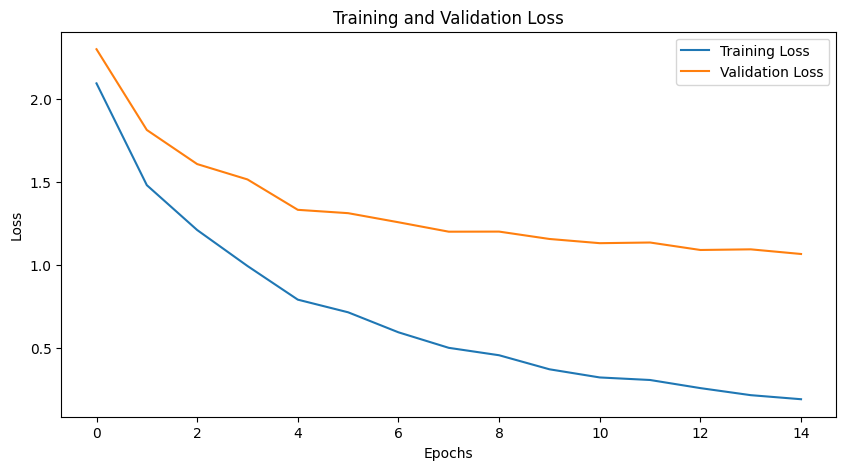

In [47]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)